# Depth dataset analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
# Positioning ROIs:
# Body
POS_BODY_FILE = '../data/positions/roi_position.pkl'
# Antenna
POS_ANTENNA_FILE = '../data/positions/antenna_position.pkl'
# Dataset of depth captures
DEPTH_DATASET_FILE = '../data/positions/c_2021_17_07_23_54_14_depth_capture.pkl'
# ROI defined for the dataset
ROI_DEFINITION_FILE = '../data/positions/roi.pkl'
# Original image size
ORIGINAL_WIDTH = 640
ORIGINAL_HEIGHT = 400
# These parameters come from intrinsics matrix (RIGHT)
CX = 318.04592896
CY = 198.99064636
FX = 427.05795288
FY = 427.38696289

In [4]:
fidant = open(POS_ANTENNA_FILE, 'rb')
antenna = pickle.load(fidant)
fidbod = open(POS_BODY_FILE, 'rb')
body = pickle.load(fidbod)
fid = open(DEPTH_DATASET_FILE, 'rb')
ds = pickle.load(fid)
fidroi = open(ROI_DEFINITION_FILE, "rb")
roi = pickle.load(fidroi)

In [5]:
antenna

{'absolute': {'topx': 129, 'topy': 25, 'bottomx': 105, 'bottomy': 46},
 'relative': {'topx': 0.2015625,
  'topy': 0.0625,
  'bottomx': 0.1640625,
  'bottomy': 0.115},
 'x': -232.6169891357422,
 'y': 187.92703247070312,
 'z': 506.0}

In [6]:
body

{'topl': [0.45, 0.10000000000000007],
 'bottomr': [0.65, 0.3],
 'x': 64.85865020751953,
 'y': 243.2199249267578,
 'z': 895.0}

In [7]:
roi

{'right_hand': {'topx': 0.2296875,
  'bottomx': 0.6546875,
  'topy': 0.0775,
  'bottomy': 0.4625},
 'left_hand': {'topx': 0.821875,
  'bottomx': 0.959375,
  'topy': 0.2525,
  'bottomy': 0.69}}

In [8]:
# Antenna
x1 = int(antenna['absolute']['topx'])
x2 = int(antenna['absolute']['bottomx'])
z = antenna['z']
x1_mm = ((x1 - CX)*z)/FX
x2_mm = ((x2 - CX)*z)/FX

In [9]:
antenna['absolute']['topx'], antenna['absolute']['bottomx'], x1_mm, x2_mm

(129, 105, -223.9912391483761, -252.42766075837798)

In [10]:
# Righ Hand
x1 = int(roi['right_hand']['topx']*ORIGINAL_WIDTH)
x2 = int(roi['right_hand']['bottomx']*ORIGINAL_WIDTH)
z = antenna['z']
x1_mm = ((x1 - CX)*z)/FX
x2_mm = ((x2 - CX)*z)/FX

In [11]:
x1, x2, x1_mm, x2_mm

(147, 419, -202.6639229408747, 119.61552197248004)

In [12]:
# Process dataset
dm_lh = []
dm_rh = []
for dm in ds:
    if dm['hand'] == 'left':
        dm_lh.append(dm)
    else:
        dm_rh.append(dm)

In [13]:
size_lh = len(dm_lh)
size_rh = len(dm_rh)

depth_map_dim_lh = dm_lh[0]['depth_map'].shape
depth_map_dim_rh = dm_rh[0]['depth_map'].shape

from_ts_lh = dm_lh[0]['timestamp']
to_ts_lh = dm_lh[size_lh-1]['timestamp']

from_ts_rh = dm_rh[0]['timestamp']
to_ts_rh = dm_rh[size_rh-1]['timestamp']

from_frame_num_lh = dm_lh[0]['frame']
to_frame_num_lh = dm_lh[size_lh-1]['frame']

from_frame_num_rh = ds[0]['frame']
to_frame_num_rh = ds[size_rh-1]['frame']

roi_topx_lh = int(roi['left_hand']['topx'] * ORIGINAL_WIDTH)
roi_bottomx_lh = int(roi['left_hand']['bottomx'] * ORIGINAL_WIDTH)
roi_topy_lh = int(roi['left_hand']['topy'] * ORIGINAL_HEIGHT)
roi_bottomy_lh = int(roi['left_hand']['bottomy'] * ORIGINAL_HEIGHT)

roi_topx_rh = int(roi['right_hand']['topx'] * ORIGINAL_WIDTH)
roi_bottomx_rh = int(roi['right_hand']['bottomx'] * ORIGINAL_WIDTH)
roi_topy_rh = int(roi['right_hand']['topy'] * ORIGINAL_HEIGHT)
roi_bottomy_rh = int(roi['right_hand']['bottomy'] * ORIGINAL_HEIGHT)

## Dataset Metadata - Left Hand

In [14]:
print(f"Dataset size = {size_lh} frames")
print(f"Depth map width = {depth_map_dim_lh[1]} pixels")
print(f"Depth map height = {depth_map_dim_lh[0]} pixels")
print(f"From time = {from_ts_lh}")
print(f"To time = {to_ts_lh}")
print(f"From frame = {from_frame_num_lh}")
print(f"To frame = {to_frame_num_lh}")
print(f"ROI top (x,y) = ({roi_topx_lh},{roi_topy_lh})")
print(f"ROI bottom (x,y) = ({roi_bottomx_lh},{roi_bottomy_lh})")

Dataset size = 418 frames
Depth map width = 89 pixels
Depth map height = 176 pixels
From time = 2021-07-17 23:54:47.024889
To time = 2021-07-17 23:55:00.932412
From frame = 913
To frame = 1330
ROI top (x,y) = (526,101)
ROI bottom (x,y) = (614,276)


## Dataset Metadata - Right Hand

In [15]:
print(f"Dataset size = {size_rh} frames")
print(f"Depth map width = {depth_map_dim_rh[1]} pixels")
print(f"Depth map height = {depth_map_dim_rh[0]} pixels")
print(f"From time = {from_ts_rh}")
print(f"To time = {to_ts_rh}")
print(f"From frame = {from_frame_num_rh}")
print(f"To frame = {to_frame_num_rh}")
print(f"ROI top (x,y) = ({roi_topx_rh},{roi_topy_rh})")
print(f"ROI bottom (x,y) = ({roi_bottomx_rh},{roi_bottomy_rh})")

Dataset size = 418 frames
Depth map width = 273 pixels
Depth map height = 155 pixels
From time = 2021-07-17 23:54:47.024889
To time = 2021-07-17 23:55:00.932412
From frame = 913
To frame = 1121
ROI top (x,y) = (147,31)
ROI bottom (x,y) = (419,185)


## Inspect Dataset (Right Hand)

In [16]:
size = size_rh

In [17]:
dataset = dm_rh

In [18]:
CURRENT_SLICE = 0
slice_size = 16
slices = size//slice_size + (0 if size%slice_size==0 else 1)
def show_slice(slice_number):
    global CURRENT_SLICE
    slice_ = dataset[slice_number*slice_size:min(slice_number*slice_size+slice_size,size)]
    images_per_row = 4
    rows = slice_size//images_per_row
    fig, axs = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(16,10))
    for idx, sl_ in enumerate(slice_):
        fn = slice_number*slice_size + idx
        row, col = idx//rows, idx%rows
        axs[row,col].imshow(sl_['depth_map'], cmap='Spectral')
        axs[row,col].set_title(f"frame {fn}")
        axs[row,col].tick_params(
            left=False, 
            right=False, 
            labelleft=False,
            labelbottom=False, 
            bottom = False
        )    
    fig.tight_layout()
    plt.show()
    CURRENT_SLICE = slice_number

In [19]:
interact(show_slice, 
         slice_number=widgets.IntSlider(min=0, max=slices-1, step=1, description='Select Slice')
)

interactive(children=(IntSlider(value=0, description='Select Slice', max=26), Output()), _dom_classes=('widget…

<function __main__.show_slice(slice_number)>

## Thresholding Depth Values

In [20]:
body_buffer = 90
antenna_buffer = 5

In [21]:
# Hard limits
# Max depth
MAX_DEPTH_VALUE = body['z'] - body_buffer
# Min depth
MIN_DEPTH_VALUE = antenna['z'] + antenna_buffer

In [22]:
MAX_DEPTH_VALUE, MIN_DEPTH_VALUE

(805.0, 511.0)

In [23]:
# Show dataset filtered
def show_filtered_slice(slice_number):
    slice_ = dataset[slice_number*slice_size:min(slice_number*slice_size+slice_size,size)]
    images_per_row = 4
    rows = slice_size//images_per_row
    fig, axs = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(16,10))
    for idx, sl_ in enumerate(slice_):
        fn = slice_number*slice_size + idx
        row, col = idx//rows, idx%rows
        # Max values turn to 0 for display
        dm_ = sl_['depth_map'].copy()
        filter_1 = dm_ > MAX_DEPTH_VALUE
        dm_[filter_1] = 2**16
        axs[row,col].imshow(dm_, cmap='rainbow')
        axs[row,col].set_title(f"frame {fn}")
        axs[row,col].tick_params(
            left=False, 
            right=False, 
            labelleft=False,
            labelbottom=False, 
            bottom = False
        )    
    fig.tight_layout()
    plt.show()

In [24]:
CURRENT_SLICE

7

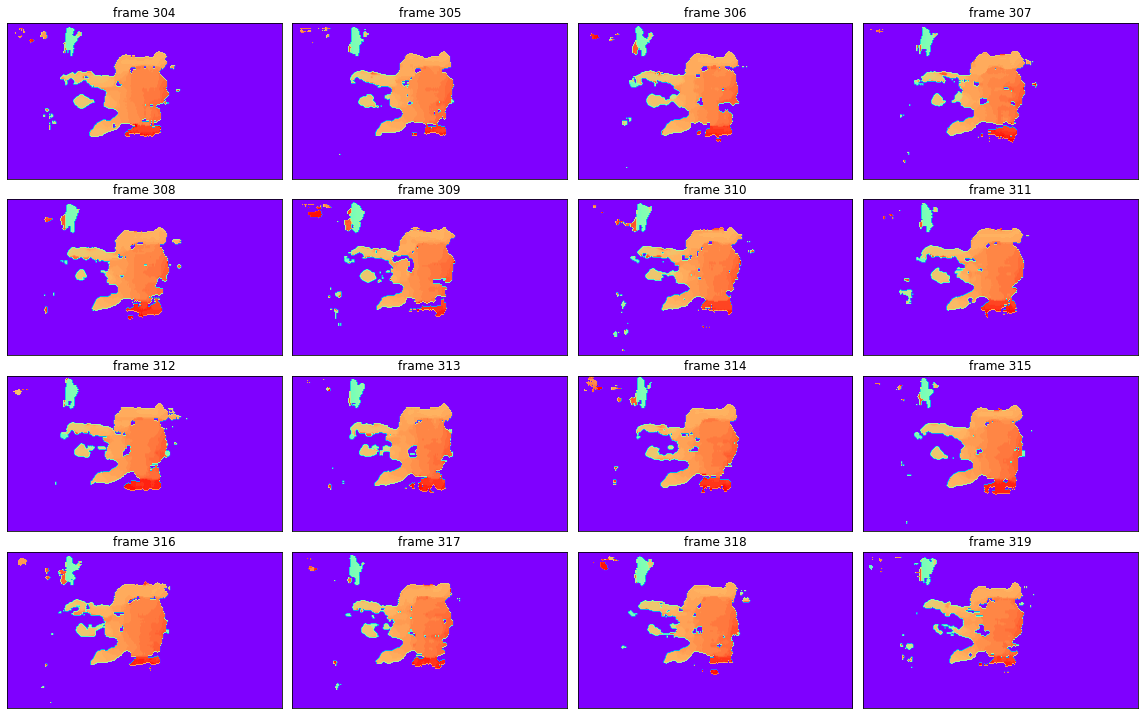

In [37]:
show_filtered_slice(CURRENT_SLICE)

## Select a Frame to inspect

In [26]:
FRAME = 120

In [27]:
dm_frame = dataset[FRAME]['depth_map']
frame_number = dataset[FRAME]['frame']
ts = dataset[FRAME]['timestamp']

In [28]:
filter_cond = (dm_frame > MAX_DEPTH_VALUE) | (dm_frame < MIN_DEPTH_VALUE)
dm_frame_filtered = dm_frame.copy()
dm_frame_filtered_idxs = np.argwhere(~filter_cond)
dm_frame_filtered_values = dm_frame[~filter_cond].flatten()
dm_frame_filtered[filter_cond] = 2**16

In [29]:
# Some statistics of the frame depth values
print("Statistics of Thresholed Frame")
print(f"Size = {len(dm_frame_filtered_values)}")
print(f"Min = {np.max(dm_frame_filtered_values)}")
print(f"Max = {np.min(dm_frame_filtered_values)}")
print(f"Mean = {np.mean(dm_frame_filtered_values)}")
print(f"Median = {np.median(dm_frame_filtered_values)}")
print(f"Std = {np.std(dm_frame_filtered_values)}")

Statistics of Thresholed Frame
Size = 4155
Min = 771
Max = 562
Mean = 630.4991576413959
Median = 625.0
Std = 39.29449043864994


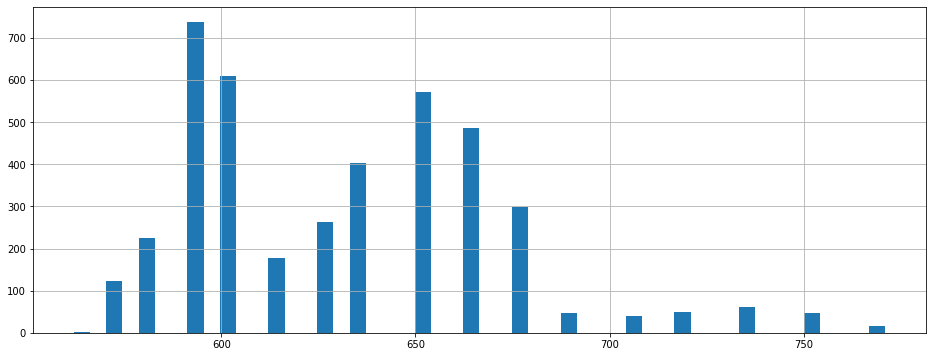

In [30]:
fig = plt.figure(figsize=(16,6))
plt.grid()
plt.hist(dm_frame_filtered_values, bins=50)
plt.show()

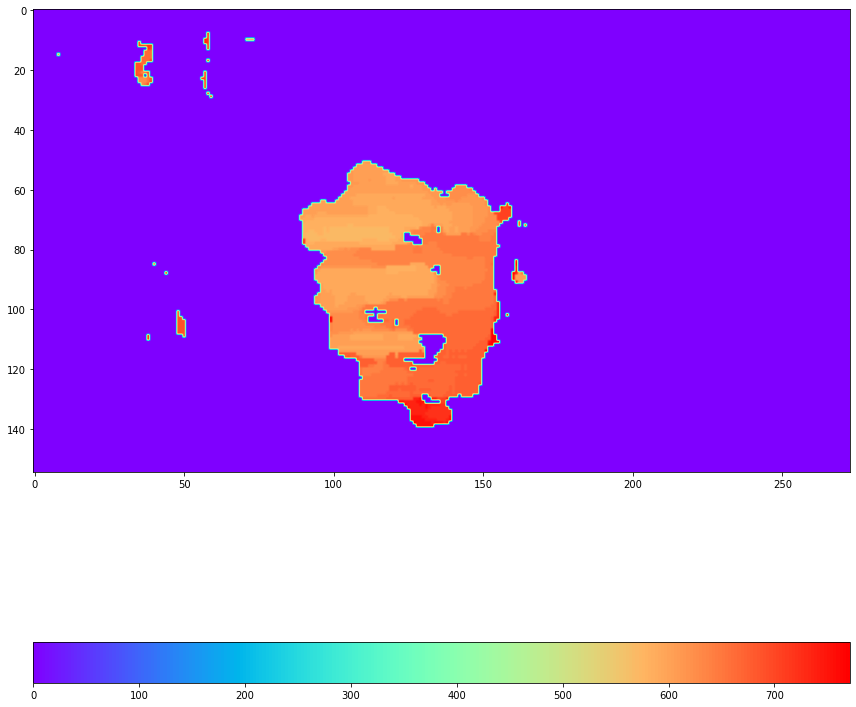

In [31]:
fig = plt.figure(figsize=(12,16))
plt.imshow(dm_frame_filtered, cmap='rainbow')
plt.colorbar(orientation='horizontal')
fig.tight_layout()
plt.show()

## Write a slice into point cloud files for future inspection

In [32]:
# Numpy version is faster
def xyz_numpy(frame, idxs, topx, topy, cx, cy, fx, fy):
    u = idxs[:,1]
    v = idxs[:,0]
    z = frame[v,u]
    x = ((u + topx - cx)*z)/fx
    y = ((v + topy - cy)*z)/fy
    return x, y, z

In [33]:
def xyz(frame, idxs, topx, topy, cx, cy, fx, fy):
    xyz_c = []
    for v, u in idxs:
        z = frame[v, u]
        x = ((u + topx - cx)*z)/fx
        y = ((v + topy - cy)*z)/fy
        xyz_c.append([x,y,z])
    return xyz_c

In [34]:
CURRENT_SLICE

7

In [35]:
roi_topx = roi_topx_rh
roi_topy = roi_topy_rh

In [36]:
print(f"Writing Current Slice {CURRENT_SLICE}")
slice_ = dataset[CURRENT_SLICE*slice_size:min(CURRENT_SLICE*slice_size+slice_size,size)]
for sl_ in slice_:
    dm_ = sl_['depth_map'].copy()
    fn = sl_['frame']
    filter_cond = (dm_ > MAX_DEPTH_VALUE) | (dm_ < MIN_DEPTH_VALUE)
    dm_frame_filtered_idxs = np.argwhere(~filter_cond)
    x, y, z = xyz_numpy(dm_, dm_frame_filtered_idxs, roi_topx, roi_topy, CX, CY, FX, FY)
    # write to file
    filename = f"{fn}.xyz"
    print(f"Writing file {filename}")
    fd = open(filename, 'w')
    for i,j,k in zip(x, y, z):
        fd.write(f"{i} {j} {k}\n")
    fd.close()

Writing Current Slice 7
Writing file 1025.xyz
Writing file 1026.xyz
Writing file 1027.xyz
Writing file 1028.xyz
Writing file 1029.xyz
Writing file 1030.xyz
Writing file 1031.xyz
Writing file 1032.xyz
Writing file 1033.xyz
Writing file 1034.xyz
Writing file 1035.xyz
Writing file 1036.xyz
Writing file 1037.xyz
Writing file 1038.xyz
Writing file 1039.xyz
Writing file 1040.xyz
